In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from tqdm import tqdm 
import numpy as np 
from sklearn.decomposition import PCA 
from sklearn.decomposition import KernelPCA
from scipy.sparse.linalg import svds
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# extract raw data and epoch it 
raw = mne.io.read_raw_eeglab('../data/sep_uwgr_prepro.set', preload=False)
events, event_id = mne.events_from_annotations(raw)

tmin = -0.05
tmax = 0.22

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=False)

Reading /Users/noelkamm/eeg_llm/notebooks/../data/sep_uwgr_prepro.fdt


/var/folders/hb/6djt3xvj4lj0rw_hcjlj9r940000gn/T/ipykernel_36565/3743173255.py:2: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab('../data/sep_uwgr_prepro.set', preload=False)


Used Annotations descriptions: [np.str_('1')]
Not setting metadata
6038 matching events found
No baseline correction applied
0 projection items activated


In [3]:
# get data and average data 
data = epochs.get_data()
avg_data = epochs.average().data

Loading data for 6038 events and 554 original time points ...
0 bad epochs dropped


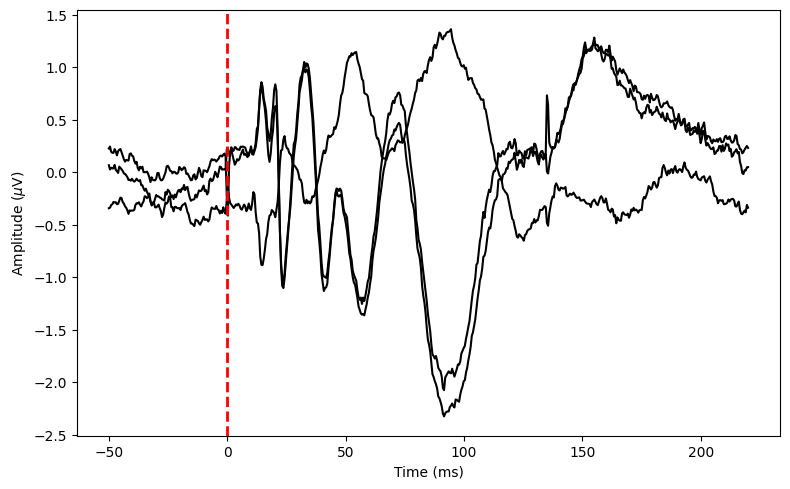

In [4]:
t = np.linspace(tmin, tmax, avg_data.shape[1]) * 1000  # convert to ms

# Channels to visualize
channels = [3, 22, 102]
labels = [f"Channel {ch}" for ch in channels]

plt.figure(figsize=(8, 5))

for ch, label in zip(channels, labels):
    plt.plot(t, avg_data[ch, :] * 1000000, color='k',label=label)

# Mark stimulus onset at 0 ms
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Stimulus onset')


plt.xlabel("Time (ms)")
plt.ylabel("Amplitude ($\mu$V)")



plt.tight_layout()
plt.savefig("../figs/sep_channels.pdf")

plt.show()


In [5]:
# fit PCA 
pca = PCA(n_components=None, svd_solver='full')
pca.fit(avg_data)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'full'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [6]:
# cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

# find number of components to reach 95% variance
n_components_95 = np.argmax(cum_var >= 0.95) + 1

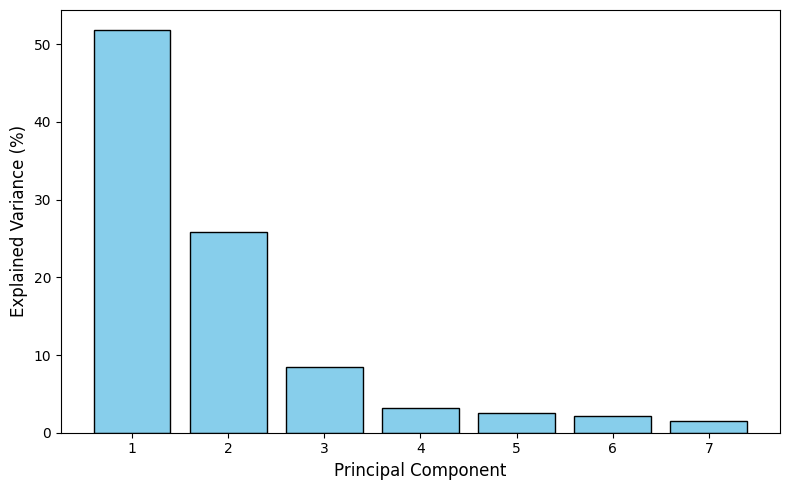

In [7]:
explained_var_ratio = pca.explained_variance_ratio_[:7]

plt.figure(figsize=(8, 5))
components = np.arange(1, len(explained_var_ratio) + 1)

plt.bar(components, explained_var_ratio * 100, color='skyblue', edgecolor='black', label='Individual variance')

plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance (%)', fontsize=12)
plt.xticks(components)

plt.tight_layout()
plt.savefig("../figs/variance_explained.pdf", format="pdf", dpi=300)

plt.show()

In [8]:
# Get the absolute Pearson correlation coefficients between the first mode and each channel's average 
first_mode = pca.components_[0]
corr = np.zeros(avg_data.shape[0]) 
for i in tqdm(range(avg_data.shape[0])):
    r = np.corrcoef(avg_data[i, :], first_mode)[0, 1]
    corr[i] = r

100%|██████████| 253/253 [00:00<00:00, 14689.76it/s]


In [9]:
montage = mne.channels.read_custom_montage('../data/standard_waveguard256_duke.elc')
raw.set_montage(montage)

/var/folders/hb/6djt3xvj4lj0rw_hcjlj9r940000gn/T/ipykernel_36565/2607384275.py:2: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


<RawEEGLAB | sep_uwgr_prepro.fdt, 253 x 3363545 (1642.4 s), ~337 KiB, data not loaded>

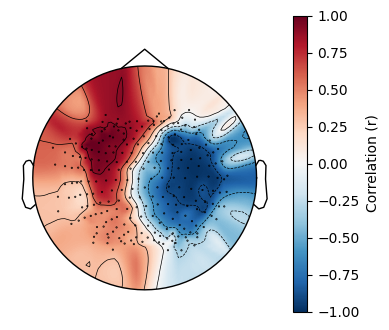

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))

im, cm = mne.viz.plot_topomap(
    corr,
    raw.info,                # or epochs.info if montage attached there
    axes=ax,
    show=False,
    vlim=(-1, 1),
)

plt.colorbar(im, ax=ax, shrink=0.8, pad=0.04, label='Correlation (r)')
plt.tight_layout()
plt.savefig("/Users/noelkamm/Desktop/Practical Work/figs/topomap_avg.pdf", format="pdf", dpi=300)
plt.show()

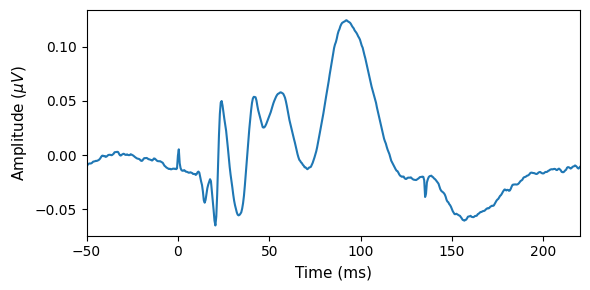

In [11]:
t = epochs.times  # in seconds

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(t * 1000, first_mode, color='tab:blue', linewidth=1.5)
ax.set_xlim(-50, 220) 

ax.set_xlabel('Time (ms)', fontsize=11)
ax.set_ylabel('Amplitude ($\mu V$)', fontsize=11)

plt.tight_layout()
plt.savefig("../figs/first_mode.pdf", format="pdf", dpi=300)
plt.show()

In [12]:
# Get the absolute Pearson correlation coefficients between the first mode and each each channel of each epoch  
corrs_single_trial = np.zeros((data.shape[0], data.shape[1]))
for epoch in tqdm(range(data.shape[0])):
    for ch in range(data.shape[1]):
        r = np.corrcoef(data[epoch, ch, :], first_mode)[0, 1]
        corrs_single_trial[epoch, ch] = r

100%|██████████| 6038/6038 [00:30<00:00, 197.83it/s]


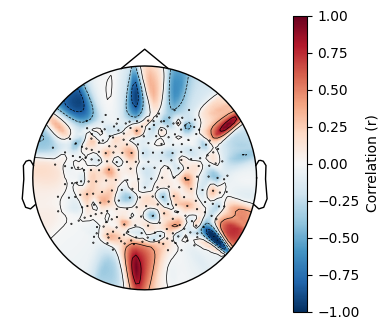

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

epoch = 50

im, cm = mne.viz.plot_topomap(
    corrs_single_trial[epoch, :],
    raw.info,                # or epochs.info if montage attached there
    axes=ax,
    show=False,
    vlim=(-1, 1),
)

plt.colorbar(im, ax=ax, shrink=0.8, pad=0.04, label='Correlation (r)')
plt.tight_layout()
plt.savefig("../figs/topomap_epoch_50.pdf", format="pdf", dpi=300)
plt.show()